In [25]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [26]:
# Load the CSV file using pandas
data = pd.read_csv('Ag_3_reduced.csv')
df = data.drop(columns=['Unnamed: 0'])
df.head()

X = df.iloc[:, 2:8].values  # Columns 1 to 5
y = df.iloc[:, 8:].values   # Columns from 6 onwards

# Splitting the data into an 80% training set and a 20% testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<ipython-input-26-83b9ff9410b9>:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('Ag_3_reduced.csv')


In [48]:
df.head()

met isHex   n2    n1  height  rad  gap  lambda_val      Ts      Tp      Rs  \
0  Ag     1  4.1  1.58     0.0    5    2         400  68.706  68.706  27.488   
1  Ag     1  4.1  1.58     0.0    5    2         402  68.208  68.208  27.733   
2  Ag     1  4.1  1.58     0.0    5    2         404  67.702  67.702  28.002   
3  Ag     1  4.1  1.58     0.0    5    2         406  67.187  67.187  28.296   
4  Ag     1  4.1  1.58     0.0    5    2         408  66.660  66.660  28.615   

       Rp  
0  27.488  
1  27.733  
2  28.002  
3  28.296  
4  28.615

In [30]:
# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [31]:
#Create a custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        x = self.features[idx]
        y = self.labels[idx]
        return x, y
train_dataset = CustomDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [53]:
#Model_FCN
# Define a fully connected neural network architecture
class FCModel(nn.Module):
    def __init__(self, num_input_features=6, num_output_values=4):
        super(FCModel, self).__init__()
        self.fc1 = nn.Linear(num_input_features, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_output_values)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out

model = FCModel(num_input_features=6, num_output_values=4)

In [ ]:
# # Training loop
# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# num_epochs = 20
# for epoch in range(num_epochs):
#     for inputs, targets in train_loader:
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, targets)
#         loss.backward()
#         optimizer.step()

#     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

In [ ]:
# Training loop
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50
losses = []  # To store loss values for each epoch
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_epoch_loss = epoch_loss / len(train_loader)
    losses.append(avg_epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}')

Epoch [1/50], Loss: 2.5787
Epoch [2/50], Loss: 2.5160
Epoch [3/50], Loss: 2.4649
Epoch [4/50], Loss: 2.4290
Epoch [5/50], Loss: 2.3905
Epoch [6/50], Loss: 2.3734
Epoch [7/50], Loss: 2.3195
Epoch [8/50], Loss: 2.2957
Epoch [9/50], Loss: 2.2700
Epoch [10/50], Loss: 2.2423
Epoch [11/50], Loss: 2.1974
Epoch [12/50], Loss: 2.1562
Epoch [13/50], Loss: 2.1504
Epoch [14/50], Loss: 2.1177
Epoch [15/50], Loss: 2.0991
Epoch [16/50], Loss: 2.0700
Epoch [17/50], Loss: 2.0524
Epoch [18/50], Loss: 2.0461
Epoch [19/50], Loss: 2.0333
Epoch [20/50], Loss: 2.0033
Epoch [21/50], Loss: 1.9922
Epoch [22/50], Loss: 1.9922
Epoch [23/50], Loss: 1.9663
Epoch [24/50], Loss: 1.9650
Epoch [25/50], Loss: 1.9466
Epoch [26/50], Loss: 1.9599
Epoch [27/50], Loss: 1.9173
Epoch [28/50], Loss: 1.9179
Epoch [29/50], Loss: 1.8998


In [38]:
# Save the trained model's weights
torch.save(model.state_dict(), 'model_weights.pth')

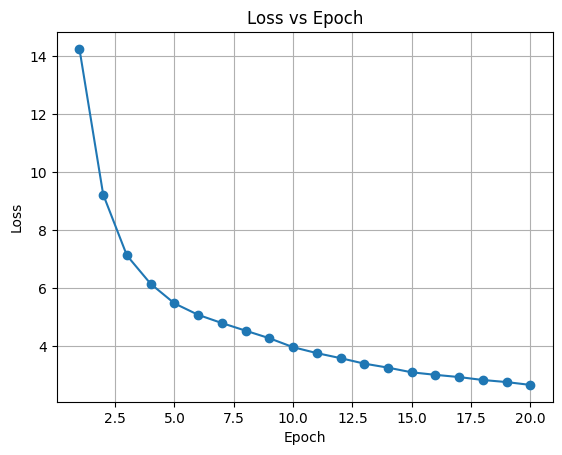

In [39]:
# Plot loss vs epoch
import matplotlib.pyplot as plt
plt.plot(range(1, num_epochs+1), losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.grid(True)
plt.show()

In [58]:
# Load the trained model's weights for testing
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()

FCModel(
  (fc1): Linear(in_features=6, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=4, bias=True)
)

In [59]:
# Test the trained model using only the loaded weights
with torch.no_grad():
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    print(f'Test Loss: {test_loss.item():.4f}')

Test Loss: 2.0506


In [ ]:
# # Test the trained model using only the loaded weights
# with torch.no_grad():
#     test_outputs = model(X_test)
#     # Extract predicted TS, TP, RS, RP values
#     predicted_ts = test_outputs[:, 0]
#     predicted_tp = test_outputs[:, 1]
#     predicted_rs = test_outputs[:, 2]
#     predicted_rp = test_outputs[:, 3]

# # Convert predictions to NumPy arrays
# predicted_ts = predicted_ts.numpy()
# predicted_tp = predicted_tp.numpy()
# predicted_rs = predicted_rs.numpy()
# predicted_rp = predicted_rp.numpy()

# # Display predicted values
# for i in range(len(predicted_ts)):
#     print(f"Sample {i+1}: Predicted TS={predicted_ts[i]:.4f}, TP={predicted_tp[i]:.4f}, RS={predicted_rs[i]:.4f}, RP={predicted_rp[i]:.4f}")

In [28]:
# # Test the trained model
# model.eval()
# with torch.no_grad():
#     test_outputs = model(X_test)
#     test_loss = criterion(test_outputs, y_test)
#     print(f'Test Loss: {test_loss.item():.4f}')

In [ ]:
# # Load the trained model's weights for testing
# model.load_state_dict(torch.load('model_weights.pth'))
# model.eval()

# # Test the trained model using only the loaded weights
# with torch.no_grad():
#     test_outputs = model(X_test)

# # Convert test outputs to NumPy arrays
# predicted_values = test_outputs.numpy()
# actual_values = y_test

# # Extract individual columns
# actual_ts = actual_values[:, 0]
# actual_tp = actual_values[:, 1]
# actual_rs = actual_values[:, 2]
# actual_rp = actual_values[:, 3]

# predicted_ts = predicted_values[:, 0]
# predicted_tp = predicted_values[:, 1]
# predicted_rs = predicted_values[:, 2]
# predicted_rp = predicted_values[:, 3]

# # Create scatter plots for each predicted vs actual pair
# plt.figure(figsize=(12, 8))

# plt.subplot(2, 2, 1)
# plt.scatter(actual_ts, predicted_ts)
# plt.xlabel('Actual TS')
# plt.ylabel('Predicted TS')
# plt.title('Actual vs. Predicted TS')

# plt.subplot(2, 2, 2)
# plt.scatter(actual_tp, predicted_tp)
# plt.xlabel('Actual TP')
# plt.ylabel('Predicted TP')
# plt.title('Actual vs. Predicted TP')

# plt.subplot(2, 2, 3)
# plt.scatter(actual_rs, predicted_rs)
# plt.xlabel('Actual RS')
# plt.ylabel('Predicted RS')
# plt.title('Actual vs. Predicted RS')

# plt.subplot(2, 2, 4)
# plt.scatter(actual_rp, predicted_rp)
# plt.xlabel('Actual RP')
# plt.ylabel('Predicted RP')
# plt.title('Actual vs. Predicted RP')

# plt.tight_layout()
# plt.show()

ValueError: ignored

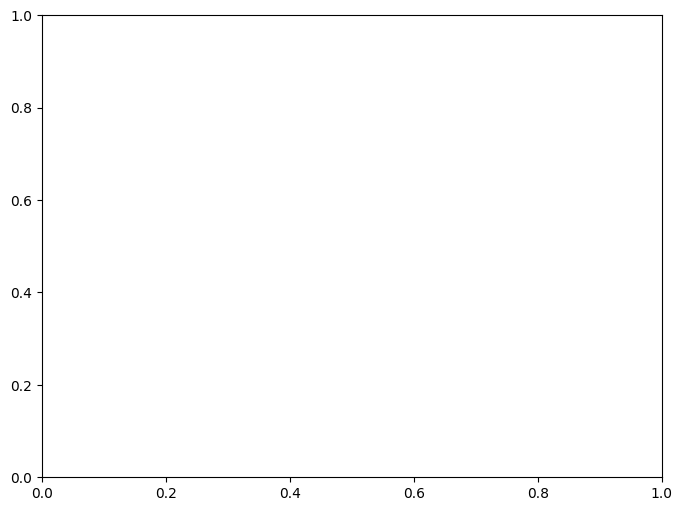

In [57]:
# Test the trained model using only the loaded weights
with torch.no_grad():
    test_outputs = model(X_test)

# Convert test outputs to NumPy arrays
predicted_values = test_outputs.numpy()
actual_values = y_test

# Extract individual columns
actual_ts = actual_values[:, 0]
predicted_ts = predicted_values[:, 0]

#lambda_val = df.iloc[:, 7].values

# Create a scatter plot of TS vs lambda_val
plt.figure(figsize=(8, 6))
plt.scatter(lambda_value, actual_ts, label='Actual TS')
plt.scatter(lambda_value, predicted_ts, label='Predicted TS')
plt.xlabel('lambda_val')
plt.ylabel('TS')
plt.title('TS vs lambda_val')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Load the trained model's weights for testing
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()

# Test the trained model using only the loaded weights
with torch.no_grad():
    test_outputs = model(X_test)

# Convert test outputs to NumPy arrays
predicted_values = test_outputs.numpy()

# Extract individual columns
actual_values = y_test
actual_ts = actual_values[:, 0]
lambda_val = actual_values[:, 7]  # Assuming lambda_val is the 8th column

predicted_ts = predicted_values[:, 0]

# Create a line plot for TS vs lambda_val
plt.figure(figsize=(10, 6))
plt.plot(lambda_val, actual_ts, label='Actual TS', marker='o')
plt.plot(lambda_val, predicted_ts, label='Predicted TS', marker='x')
plt.xlabel('lambda_val')
plt.ylabel('TS')
plt.title('TS vs lambda_val')
plt.legend()
plt.grid(True)
plt.show()